In [1]:
import pandas as pd
import numpy as np
import os
import pysam
import seaborn as sns
import pyreadr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import scipy
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io

import nb_util as nb

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
df = pd.read_csv(fpath)
df = df.set_index('geneName')
gene_names = df.index.to_list()

raw = df.reset_index(drop=False)

raw = pd.melt(raw, id_vars='geneName')
raw['timepoint'] = raw['variable'].map(nb.tmap)
raw['replicate'] = raw['variable'].map(nb.rmap)
raw['control'] = raw['variable'].map(nb.cmap)
raw['hours'] = raw['timepoint'] * 8

raw.head()

,geneName,variable,value,timepoint,replicate,control,hours
0,A1BG,S1a,12,0,r1c,control,0
1,A1CF,S1a,0,0,r1c,control,0
2,A2M,S1a,0,0,r1c,control,0
3,A2ML1,S1a,0,0,r1c,control,0
4,A3GALT2,S1a,0,0,r1c,control,0


In [3]:
mt_genes = [x for x in raw['geneName'].unique() if x.startswith('MT-')]
print(len(mt_genes))


df = raw[raw['geneName'].isin(mt_genes)].reset_index(drop=True)
df = df.drop(columns=['variable'])
df.head()

13


,geneName,value,timepoint,replicate,control,hours
0,MT-ATP6,24703,0,r1c,control,0
1,MT-ATP8,10704,0,r1c,control,0
2,MT-CO1,113487,0,r1c,control,0
3,MT-CO2,54362,0,r1c,control,0
4,MT-CO3,72061,0,r1c,control,0


In [4]:
[print(x) for x in mt_genes]

MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


[None, None, None, None, None, None, None, None, None, None, None, None, None]

Text(0.5, 11.166666666666647, 'Hours/Replicate')

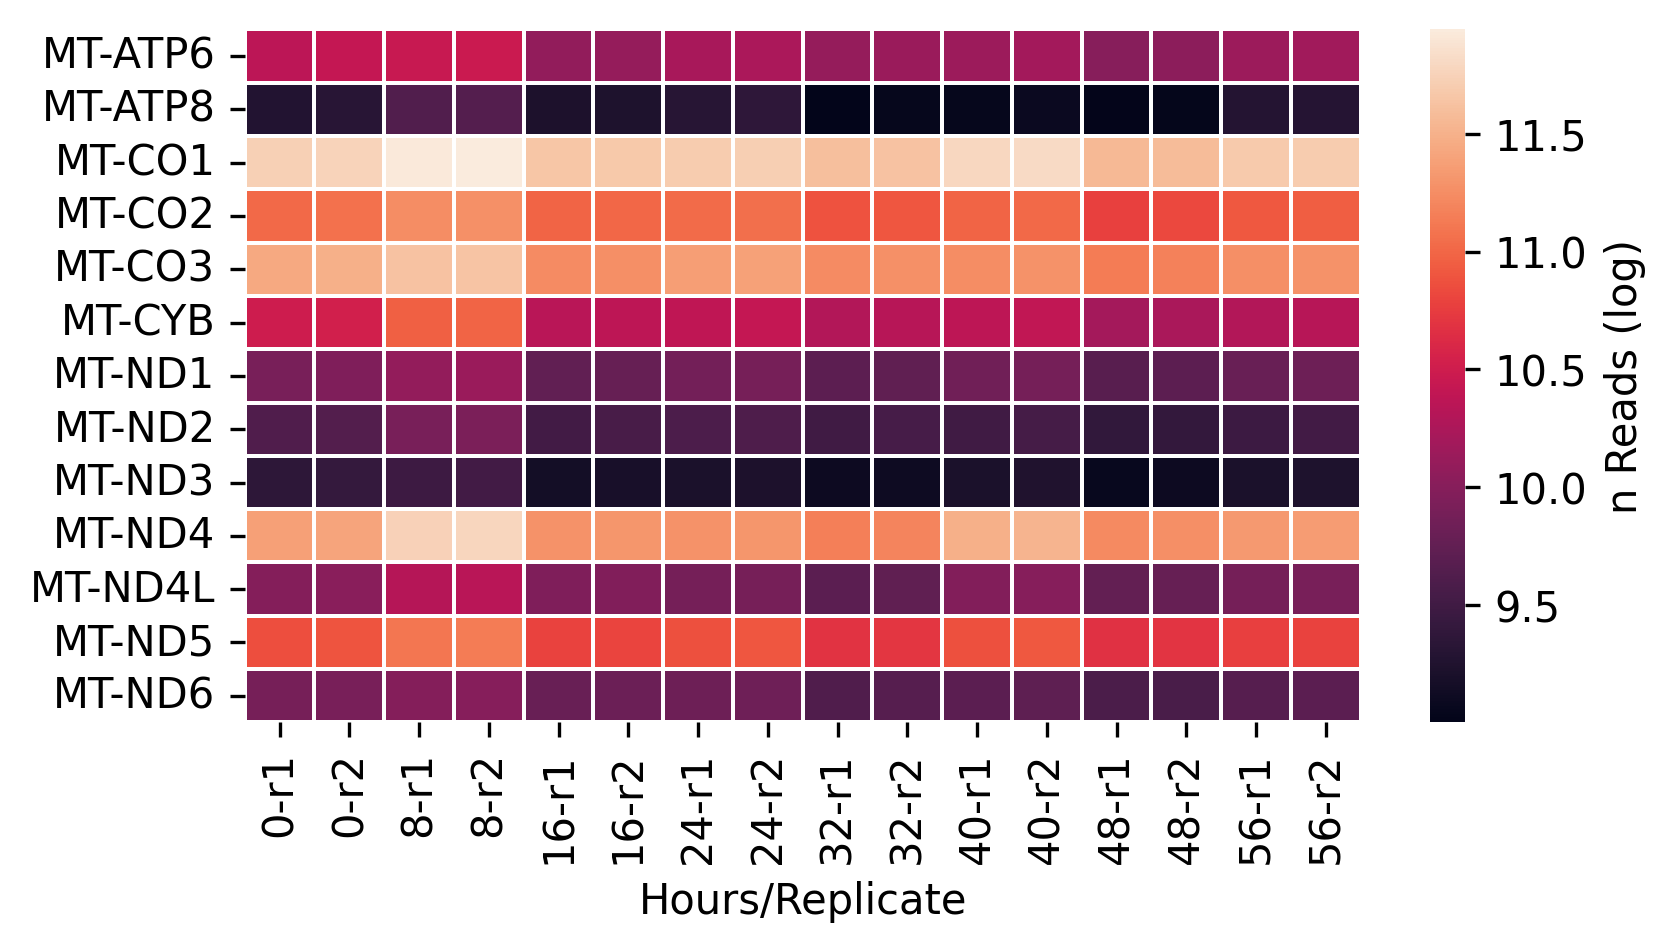

In [5]:
pdf = df.copy()
pdf = pdf[pdf['control'] != 'control']
pdf = pd.pivot_table(pdf, 
                     index='geneName', 
                     columns=['hours', 'replicate'],
                     values='value',)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.heatmap(np.log1p(pdf),
            lw=0.5,
            cbar_kws={'label' : 'n Reads (log)'})

plt.ylabel("")
plt.xlabel("Hours/Replicate")
# pdf.head()

In [6]:
dirpath = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/featureCounts/"

df = []

for f in os.listdir(dirpath):
    if not f.endswith(".summary"):
        file_id = f.split(".")[0]

        fpath = f"{dirpath}{f}"
        tmp = pd.read_csv(fpath, sep='\t', comment='#')
        tmp = tmp[tmp['Chr'] == 'MT'].reset_index(drop=True)
        col = tmp.columns[-1]
        tmp = tmp[['Geneid', col]]
        tmp.columns = ['gene_id', 'read_count']
        tmp['file_id'] = file_id
        tmp['timepoint'] = tmp['file_id'].map(nb.tmap)
        tmp['replicate'] = tmp['file_id'].map(nb.rmap)
        tmp['control'] = tmp['file_id'].map(nb.cmap)
    
        df.append(tmp)

        
df = pd.concat(df, ignore_index=True)
print(f"{df.shape=}")
df.head()

df.shape=(666, 6)


,gene_id,read_count,file_id,timepoint,replicate,control
0,ENSG00000210049,297,S6a,4,r1,timecourse
1,ENSG00000211459,20787,S6a,4,r1,timecourse
2,ENSG00000210077,3,S6a,4,r1,timecourse
3,ENSG00000210082,128670,S6a,4,r1,timecourse
4,ENSG00000209082,50,S6a,4,r1,timecourse


Text(0.5, 176.16666666666663, 'Hours/Replicate')

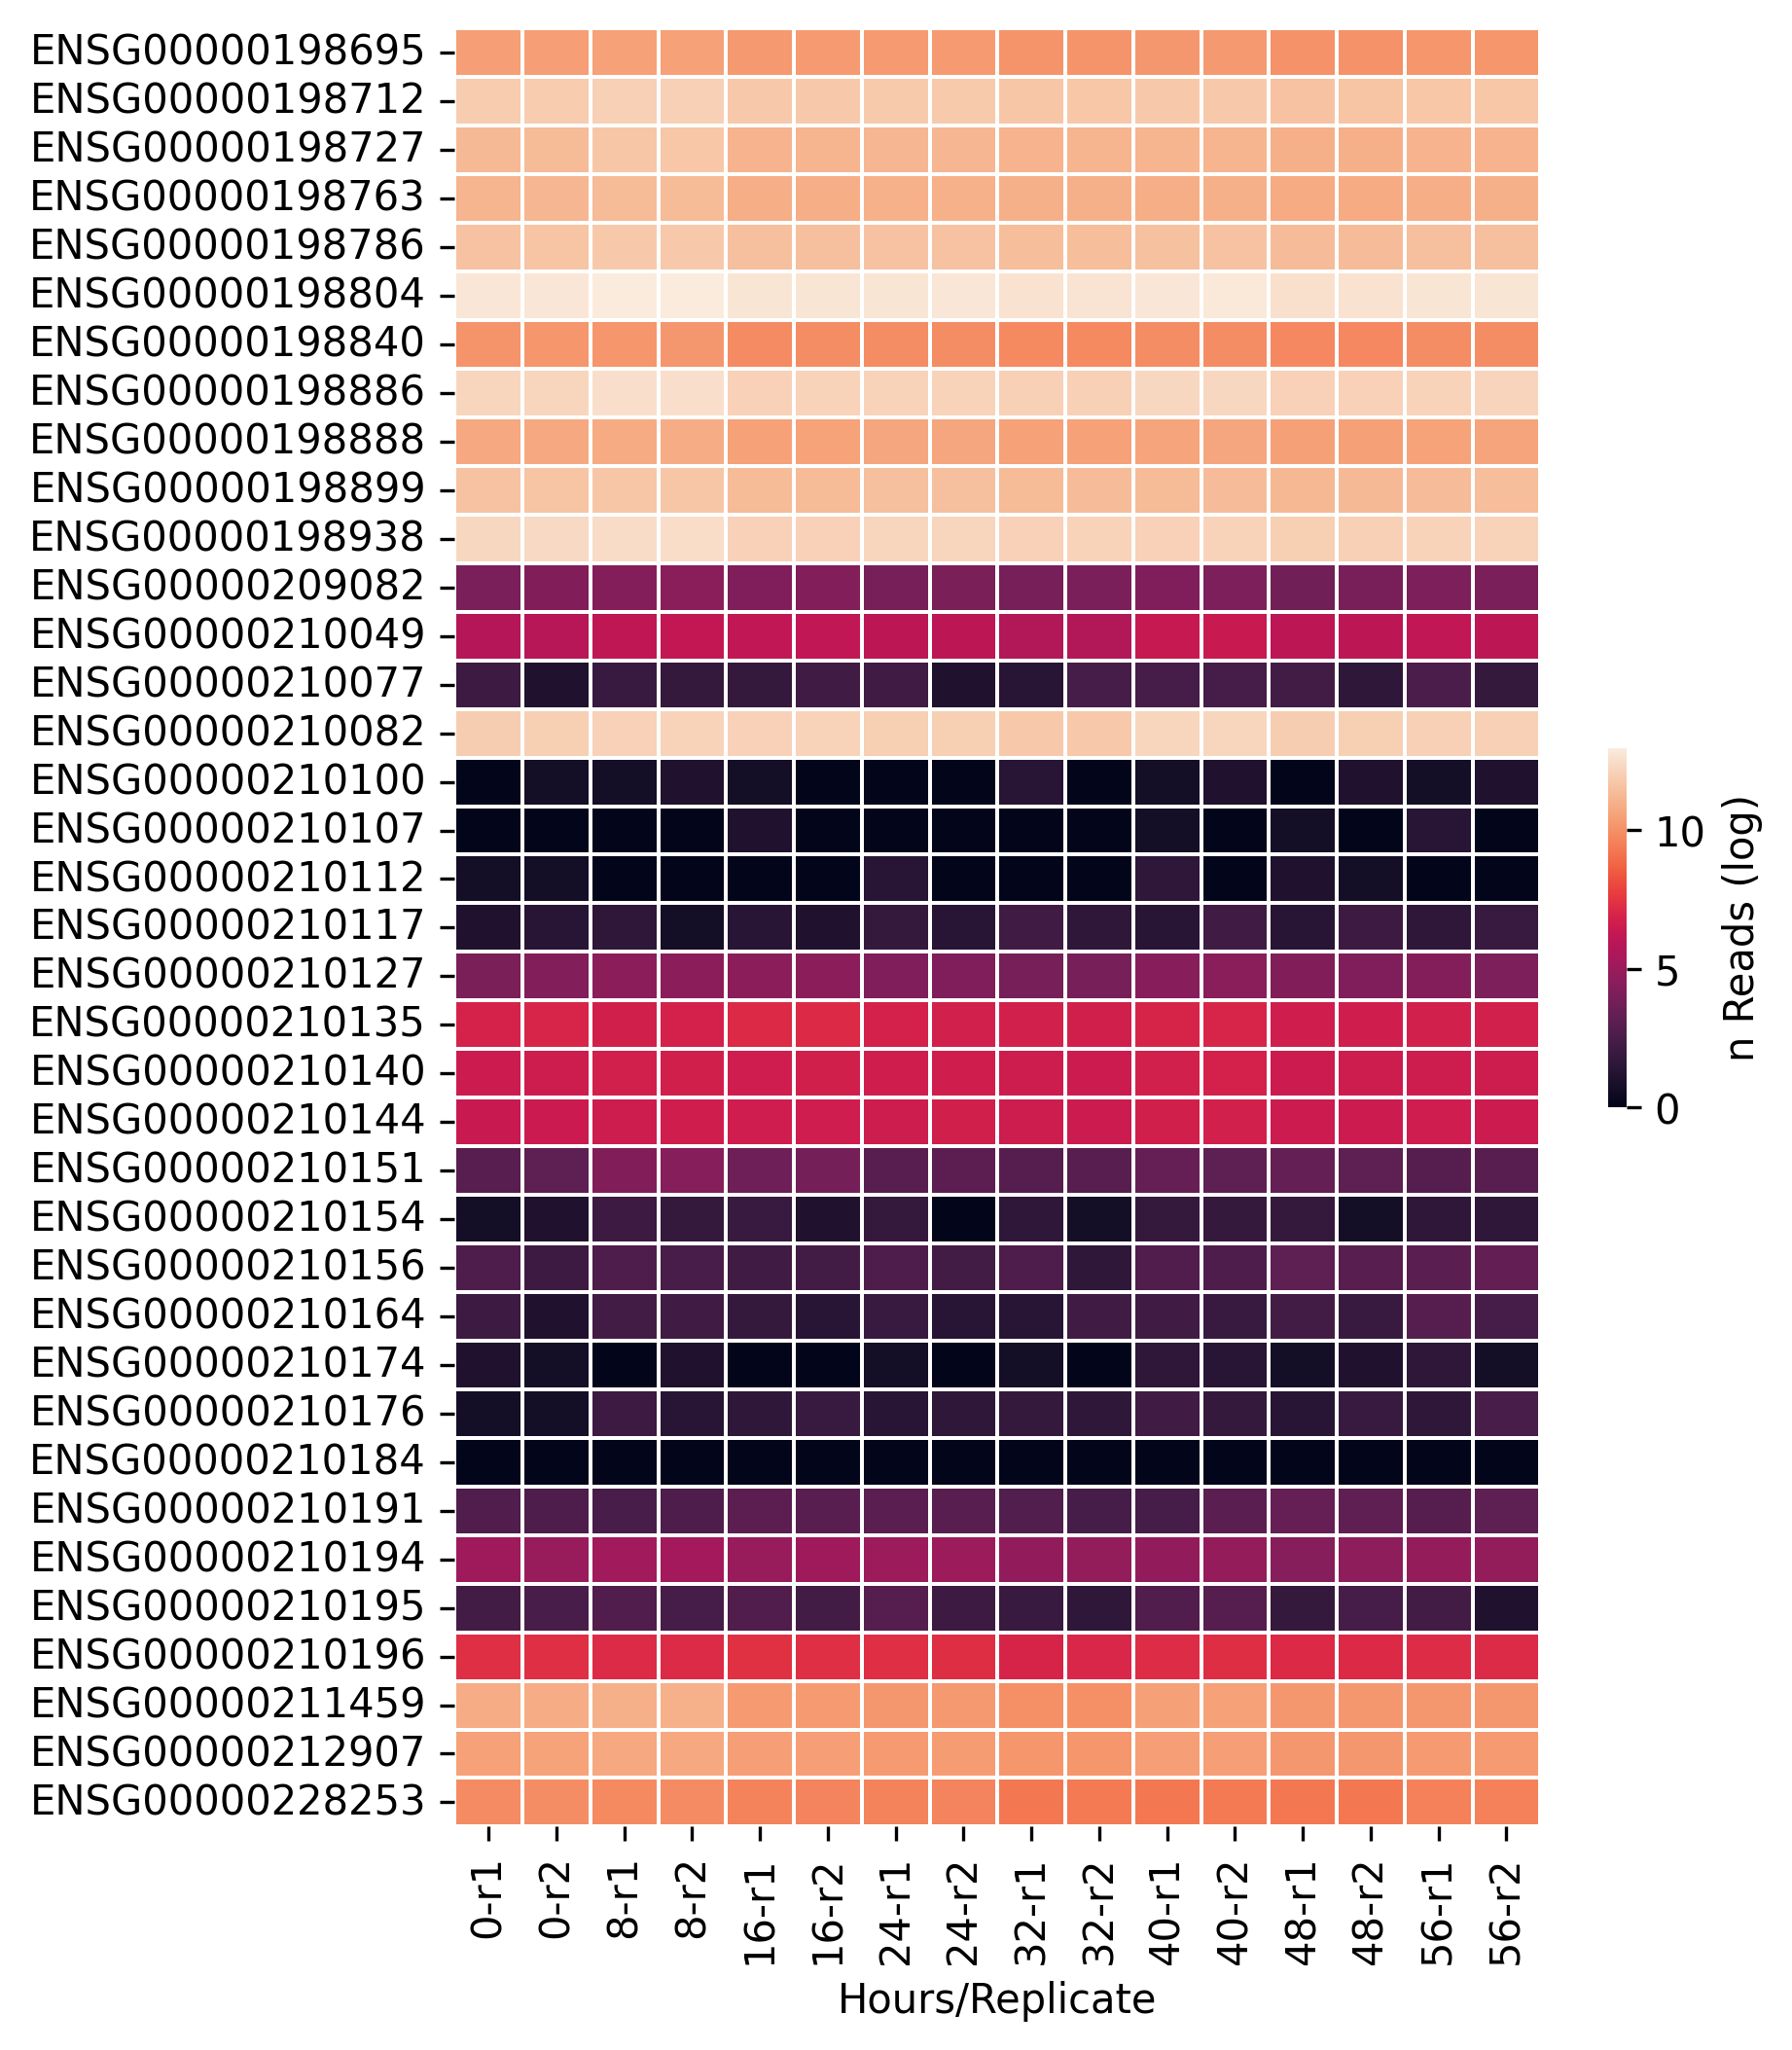

In [7]:
pdf = df.copy()
pdf = pdf[pdf['control'] != 'control']
pdf['hours'] = pdf['timepoint'] * 8

pdf = pd.pivot_table(pdf, 
                     index='gene_id', 
                     columns=['hours', 'replicate'],
                     values='read_count')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 8

sns.heatmap(np.log1p(pdf),
            lw=0.5,
            cbar_kws={'label' : 'n Reads (log)', 'shrink' : 0.2})


plt.ylabel("")
plt.xlabel("Hours/Replicate")


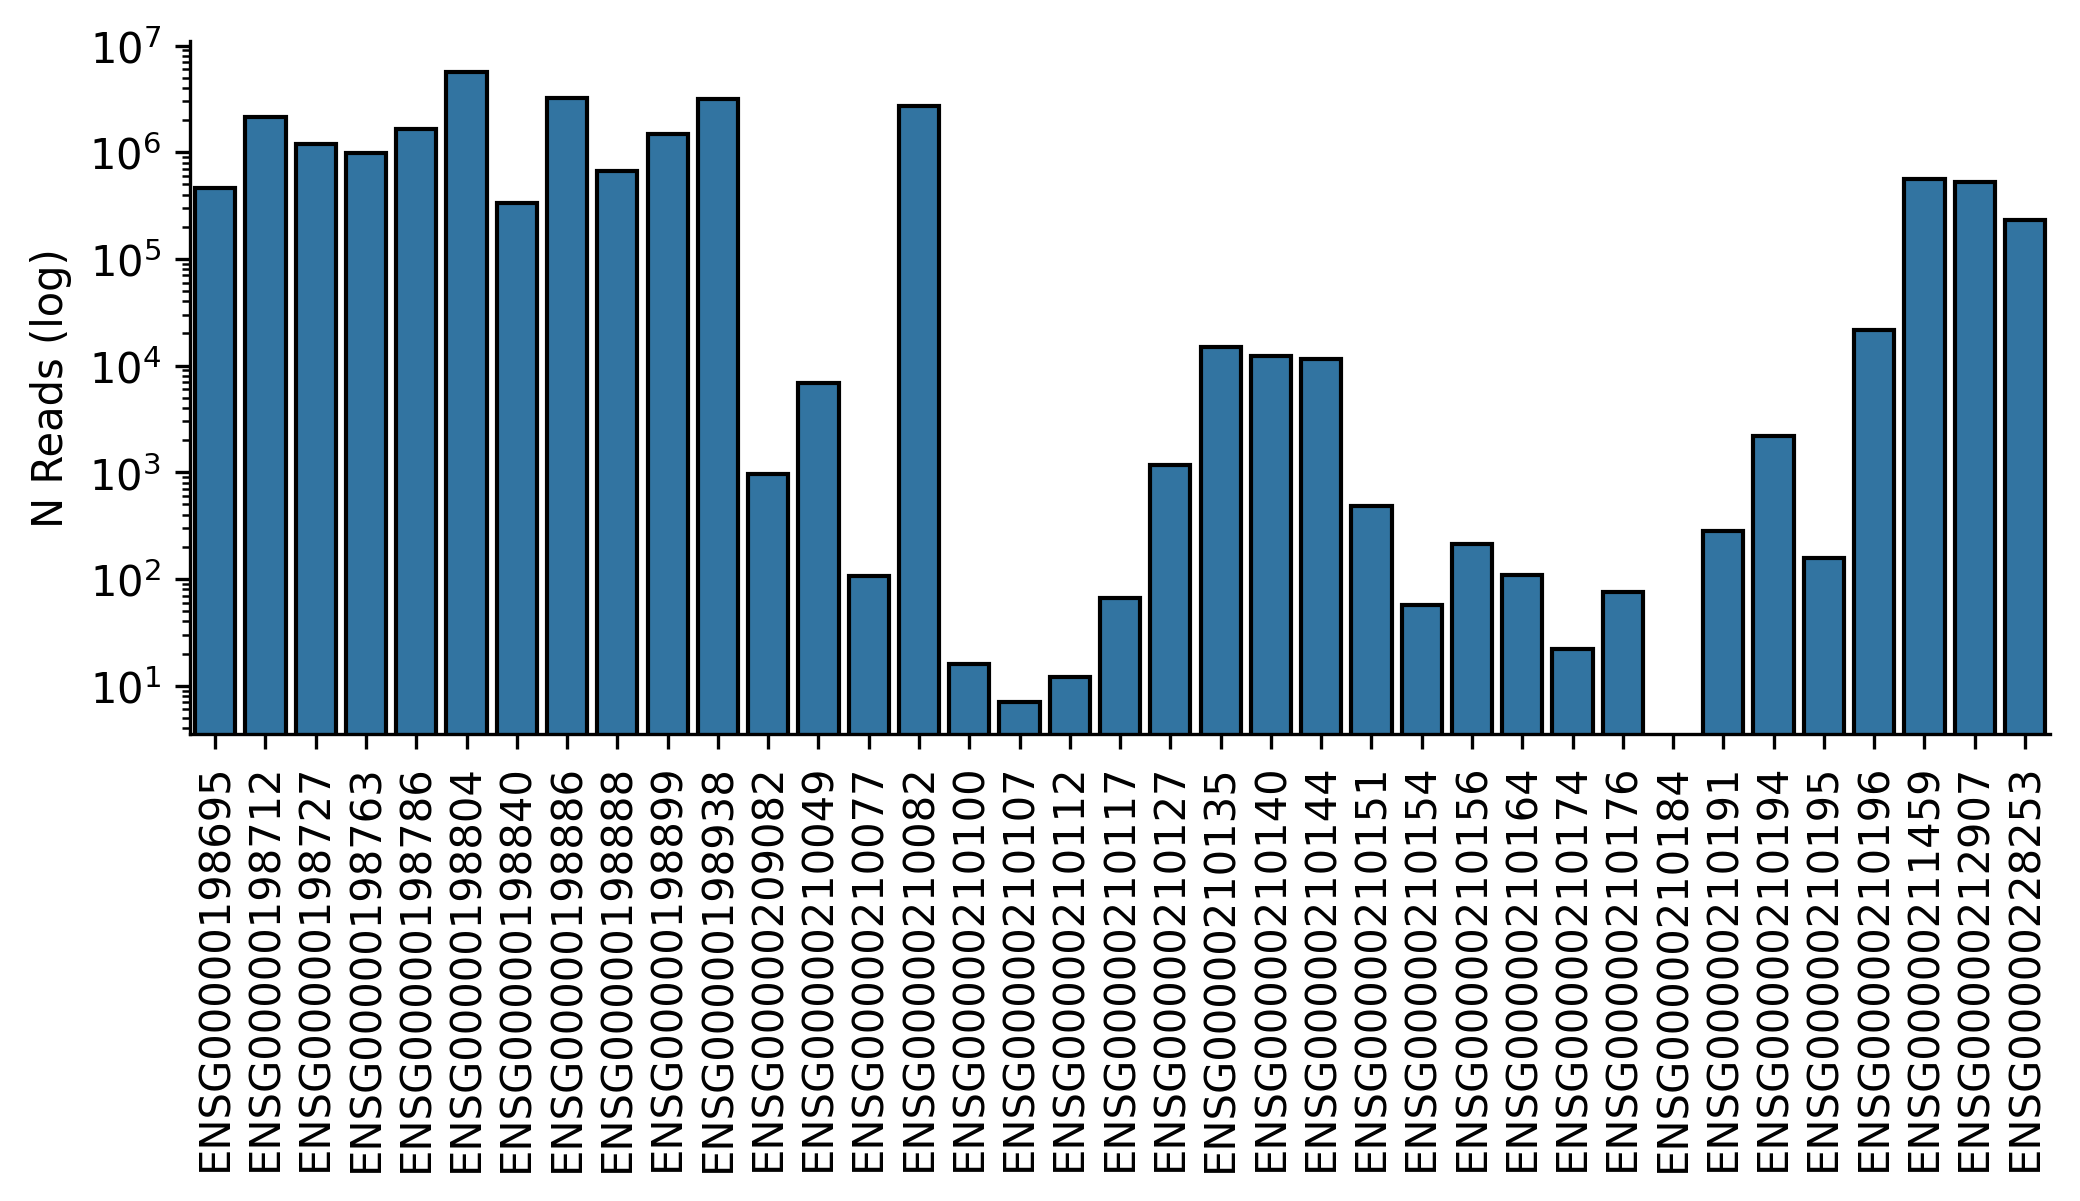

In [8]:
tmp = pdf.sum(axis=1).reset_index(drop=False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3

sns.barplot(data=tmp,
            x='gene_id',
            y=0,
            color='C0',
            ec='k')

plt.ylabel('N Reads (log)')
plt.yscale('log')
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)
sns.despine()

In [9]:
pdf.head()

hours                0               8               16              24  \
replicate            r1      r2      r1      r2      r1      r2      r1   
gene_id                                                                   
ENSG00000198695   33206   33711   36406   37446   29223   29674   29834   
ENSG00000198712  143853  148427  168311  171549  130658  134395  136428   
ENSG00000198727   79436   81721  120157  121949   65620   67281   70378   
ENSG00000198763   68036   70061   82023   83682   55275   56589   61943   
ENSG00000198786  108309  111153  128339  131193   96600   98542  106264   

hours                        32              40              48          \
replicate            r2      r1      r2      r1      r2      r1      r2   
gene_id                                                                   
ENSG00000198695   30620   24235   25134   27713   28469   23369   23441   
ENSG00000198712  139154  119982  123029  130080  133310  108645  112159   
ENSG00000198727   71934   64185   66177   66153   67865   57563   59377   
ENSG00000198763   62526   56932   58536   56117   56897   49734   50107   
ENSG00000198786  109434   89734   91570  103555  106099   86885   88473   

hours                56          
replicate            r1      r2  
gene_id                          
ENSG00000198695   25290   26268  
ENSG00000198712  123073  126295  
ENSG00000198727   64631   65920  
ENSG00000198763   55611   57309  
ENSG00000198786   95625   97735